<a href="https://colab.research.google.com/github/Volks44/VITMMA19/blob/main/Milestone_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load the dataset

In [40]:
import keras
from keras.datasets import cifar10
!pip install np_utils --quiet
import np_utils as np_utils
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import numpy as np
from matplotlib import pyplot
!pip install -q wandb
import wandb
wandb.login(key="a8b8eb57a9fc053a10a60cc53823334a37b0849e")

# load the pre-shuffled train and test data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Visualize the first Training Images

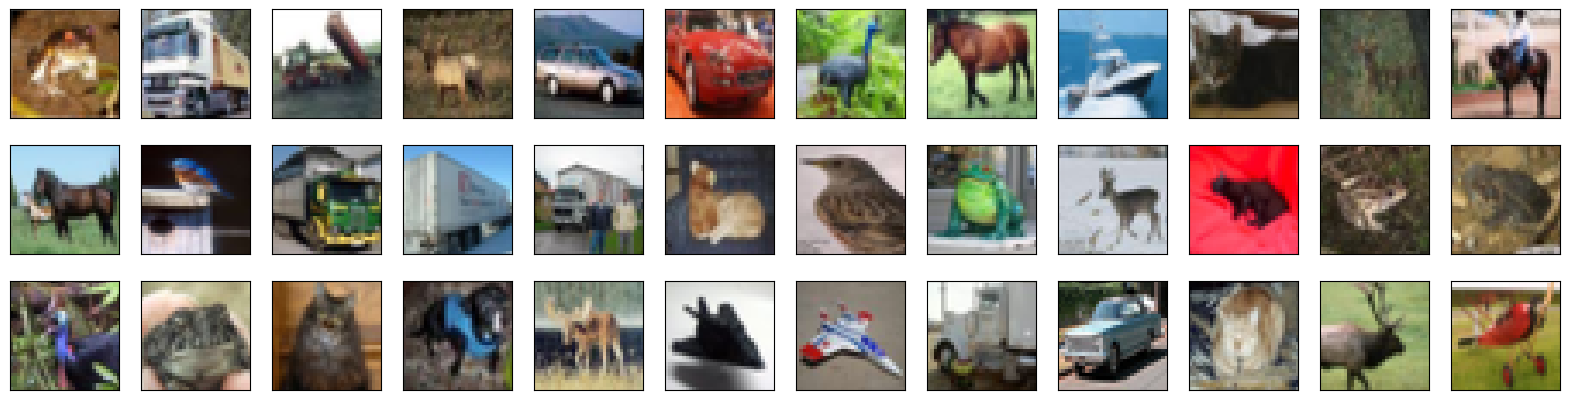

In [41]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))

Image preprocesing

In [42]:
# rescale [0,255] --> [0,1]
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

Split dataset and one-hot encoding

In [43]:
# one-hot encode the labels
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# break training set into training and validation sets
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# print shape of training set
print('x_train shape:', x_train.shape)

# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

x_train shape: (45000, 32, 32, 3)
45000 train samples
10000 test samples
5000 validation samples


Define the model and hyperparameters

In [44]:
wandb.init(project="Deep_Learning_Proj",
    config={
            "base_hidden_units": 92,
            "optimizer": "Adam",
            "loss": "sparse_categorical_crossentropy",
            "metric": "accuracy",
            "epoch": 100,
            "batch_size": 256,
            "weight_decay": 0.00011091623102216461,
            "learning_rate": 9.391826819704956e-05
        },
    )
config = wandb.config

In [45]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# l2 regularization hyperparameter
weight_decay = config.weight_decay

model = Sequential()

# CONV1
# notice that we defined the input_shape here because this is the first CONV layer.
# we don’t need to do that for the remaining layers
model.add(Conv2D(config.base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV2
model.add(Conv2D(config.base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# CONV3
model.add(Conv2D(2*config.base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV4
model.add(Conv2D(2*config.base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# CONV5
model.add(Conv2D(4*config.base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV6
model.add(Conv2D(4*config.base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# FC7
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

# print model summary

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 92)        2576      
                                                                 
 activation_12 (Activation)  (None, 32, 32, 92)        0         
                                                                 
 batch_normalization_12 (Ba  (None, 32, 32, 92)        368       
 tchNormalization)                                               
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 92)        76268     
                                                                 
 activation_13 (Activation)  (None, 32, 32, 92)        0         
                                                                 
 batch_normalization_13 (Ba  (None, 32, 32, 92)        368       
 tchNormalization)                                    

Data augmentation

In [46]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )

# compute the data augmentation on the training set
datagen.fit(x_train)

Train the model

In [47]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbEvalCallback
import tensorflow as tf

In [48]:
# training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

callbacks = [
        WandbMetricsLogger(),
        WandbModelCheckpoint(filepath="my_model",verbose=1, monitor='val_accuracy',save_best_only=True), early_stopping
    ]
model.compile(loss='categorical_crossentropy', optimizer=config.optimizer, metrics=['accuracy'])
history = model.fit(datagen.flow(x_train, y_train, batch_size=config.batch_size), validation_data=(x_test, y_test),
                steps_per_epoch=x_train.shape[0] // config.batch_size, epochs=config.epoch,verbose=2,callbacks=[callbacks])
wandb.finish()

Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.10100, saving model to my_model


wandb: Adding directory to artifact (./my_model)... Done. 0.1s


175/175 - 52s - loss: 2.2435 - accuracy: 0.3999 - val_loss: 3.9876 - val_accuracy: 0.1010 - 52s/epoch - 296ms/step
Epoch 2/100

Epoch 2: val_accuracy improved from 0.10100 to 0.14900, saving model to my_model


wandb: Adding directory to artifact (./my_model)... Done. 0.1s


175/175 - 39s - loss: 1.7341 - accuracy: 0.5417 - val_loss: 4.0040 - val_accuracy: 0.1490 - 39s/epoch - 222ms/step
Epoch 3/100

Epoch 3: val_accuracy improved from 0.14900 to 0.36110, saving model to my_model


wandb: Adding directory to artifact (./my_model)... Done. 0.1s


175/175 - 34s - loss: 1.6763 - accuracy: 0.5836 - val_loss: 10.1208 - val_accuracy: 0.3611 - 34s/epoch - 196ms/step
Epoch 4/100

Epoch 4: val_accuracy did not improve from 0.36110


wandb: Adding directory to artifact (./my_model)... Done. 0.1s


175/175 - 33s - loss: 1.7211 - accuracy: 0.5814 - val_loss: 5.3053 - val_accuracy: 0.3435 - 33s/epoch - 187ms/step
Epoch 5/100

Epoch 5: val_accuracy improved from 0.36110 to 0.66570, saving model to my_model


wandb: Adding directory to artifact (./my_model)... Done. 0.1s


175/175 - 36s - loss: 1.3190 - accuracy: 0.6488 - val_loss: 1.2614 - val_accuracy: 0.6657 - 36s/epoch - 207ms/step
Epoch 6/100

Epoch 6: val_accuracy improved from 0.66570 to 0.68670, saving model to my_model


wandb: Adding directory to artifact (./my_model)... Done. 0.1s


175/175 - 36s - loss: 1.1462 - accuracy: 0.6922 - val_loss: 1.2271 - val_accuracy: 0.6867 - 36s/epoch - 203ms/step
Epoch 7/100

Epoch 7: val_accuracy improved from 0.68670 to 0.71150, saving model to my_model


wandb: Adding directory to artifact (./my_model)... Done. 0.1s


175/175 - 36s - loss: 1.0495 - accuracy: 0.7230 - val_loss: 1.1074 - val_accuracy: 0.7115 - 36s/epoch - 208ms/step
Epoch 8/100

Epoch 8: val_accuracy improved from 0.71150 to 0.71750, saving model to my_model


wandb: Adding directory to artifact (./my_model)... Done. 0.1s


175/175 - 36s - loss: 0.9618 - accuracy: 0.7486 - val_loss: 1.1062 - val_accuracy: 0.7175 - 36s/epoch - 203ms/step
Epoch 9/100

Epoch 9: val_accuracy improved from 0.71750 to 0.77260, saving model to my_model


wandb: Adding directory to artifact (./my_model)... Done. 0.1s


175/175 - 37s - loss: 0.9248 - accuracy: 0.7603 - val_loss: 0.9075 - val_accuracy: 0.7726 - 37s/epoch - 210ms/step
Epoch 10/100

Epoch 10: val_accuracy did not improve from 0.77260


wandb: Adding directory to artifact (./my_model)... Done. 0.1s


175/175 - 33s - loss: 0.8727 - accuracy: 0.7767 - val_loss: 0.9303 - val_accuracy: 0.7649 - 33s/epoch - 187ms/step
Epoch 11/100

Epoch 11: val_accuracy did not improve from 0.77260


wandb: Adding directory to artifact (./my_model)... Done. 0.1s


175/175 - 32s - loss: 0.8461 - accuracy: 0.7877 - val_loss: 1.0049 - val_accuracy: 0.7469 - 32s/epoch - 182ms/step
Epoch 12/100

Epoch 12: val_accuracy improved from 0.77260 to 0.80200, saving model to my_model


wandb: Adding directory to artifact (./my_model)... Done. 0.1s


175/175 - 36s - loss: 0.8218 - accuracy: 0.7960 - val_loss: 0.8423 - val_accuracy: 0.8020 - 36s/epoch - 208ms/step
Epoch 13/100

Epoch 13: val_accuracy improved from 0.80200 to 0.80800, saving model to my_model


wandb: Adding directory to artifact (./my_model)... Done. 0.1s


175/175 - 35s - loss: 0.7784 - accuracy: 0.8118 - val_loss: 0.8095 - val_accuracy: 0.8080 - 35s/epoch - 202ms/step
Epoch 14/100

Epoch 14: val_accuracy did not improve from 0.80800


wandb: Adding directory to artifact (./my_model)... Done. 0.1s


175/175 - 32s - loss: 0.7613 - accuracy: 0.8164 - val_loss: 0.9681 - val_accuracy: 0.7498 - 32s/epoch - 181ms/step
Epoch 15/100

Epoch 15: val_accuracy improved from 0.80800 to 0.81930, saving model to my_model


wandb: Adding directory to artifact (./my_model)... Done. 0.1s


175/175 - 36s - loss: 0.7438 - accuracy: 0.8248 - val_loss: 0.7793 - val_accuracy: 0.8193 - 36s/epoch - 205ms/step
Epoch 16/100

Epoch 16: val_accuracy did not improve from 0.81930


wandb: Adding directory to artifact (./my_model)... Done. 0.1s


175/175 - 33s - loss: 0.7366 - accuracy: 0.8287 - val_loss: 0.9859 - val_accuracy: 0.7676 - 33s/epoch - 188ms/step
Epoch 17/100

Epoch 17: val_accuracy improved from 0.81930 to 0.83030, saving model to my_model


wandb: Adding directory to artifact (./my_model)... Done. 0.1s


175/175 - 36s - loss: 0.7017 - accuracy: 0.8410 - val_loss: 0.7692 - val_accuracy: 0.8303 - 36s/epoch - 205ms/step
Epoch 18/100

Epoch 18: val_accuracy did not improve from 0.83030


wandb: Adding directory to artifact (./my_model)... Done. 0.1s


175/175 - 38s - loss: 0.6874 - accuracy: 0.8468 - val_loss: 0.8297 - val_accuracy: 0.8083 - 38s/epoch - 218ms/step
Epoch 19/100

Epoch 19: val_accuracy did not improve from 0.83030


wandb: Adding directory to artifact (./my_model)... Done. 0.1s


175/175 - 33s - loss: 0.6892 - accuracy: 0.8459 - val_loss: 0.9329 - val_accuracy: 0.7866 - 33s/epoch - 187ms/step
Epoch 20/100

Epoch 20: val_accuracy did not improve from 0.83030


wandb: Adding directory to artifact (./my_model)... Done. 0.1s


175/175 - 34s - loss: 0.7174 - accuracy: 0.8411 - val_loss: 0.9067 - val_accuracy: 0.7983 - 34s/epoch - 192ms/step
Epoch 21/100

Epoch 21: val_accuracy did not improve from 0.83030


wandb: Adding directory to artifact (./my_model)... Done. 0.1s


175/175 - 33s - loss: 0.7287 - accuracy: 0.8405 - val_loss: 0.8626 - val_accuracy: 0.8145 - 33s/epoch - 187ms/step
Epoch 22/100

Epoch 22: val_accuracy did not improve from 0.83030


wandb: Adding directory to artifact (./my_model)... Done. 0.1s


175/175 - 32s - loss: 0.6932 - accuracy: 0.8544 - val_loss: 0.9583 - val_accuracy: 0.7857 - 32s/epoch - 185ms/step


epoch/accuracy,▁▃▄▄▅▆▆▆▇▇▇▇▇▇████████
epoch/epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▆▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▃▃▆▇▇▇▇▇▇██▇█▇██████
epoch/val_loss,▃▃█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.85437
epoch/epoch,21
epoch/learning_rate,0.001
epoch/loss,0.69325
epoch/val_accuracy,0.7857


Evaluate the model

In [49]:
# evaluating the model
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

79/79 [==============================] - 1s 15ms/step - loss: 0.7692 - accuracy: 0.8303

Test result: 83.030 loss: 0.769




> Learning curves



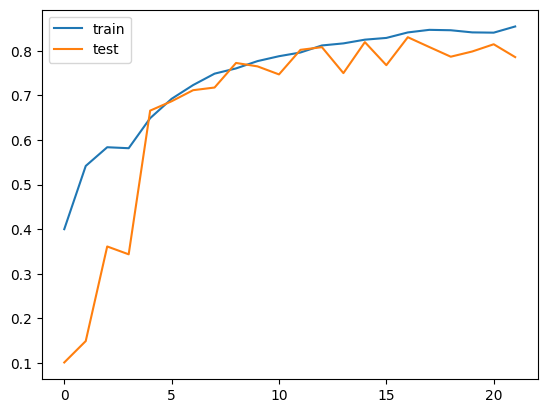

In [50]:
# plot learning curves of model accuracy
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

Visual Test

In [51]:
# get  on the test set
y_hat = model.predict(x_test)

# define text labels
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

313/313 [==============================] - 1s 4ms/step


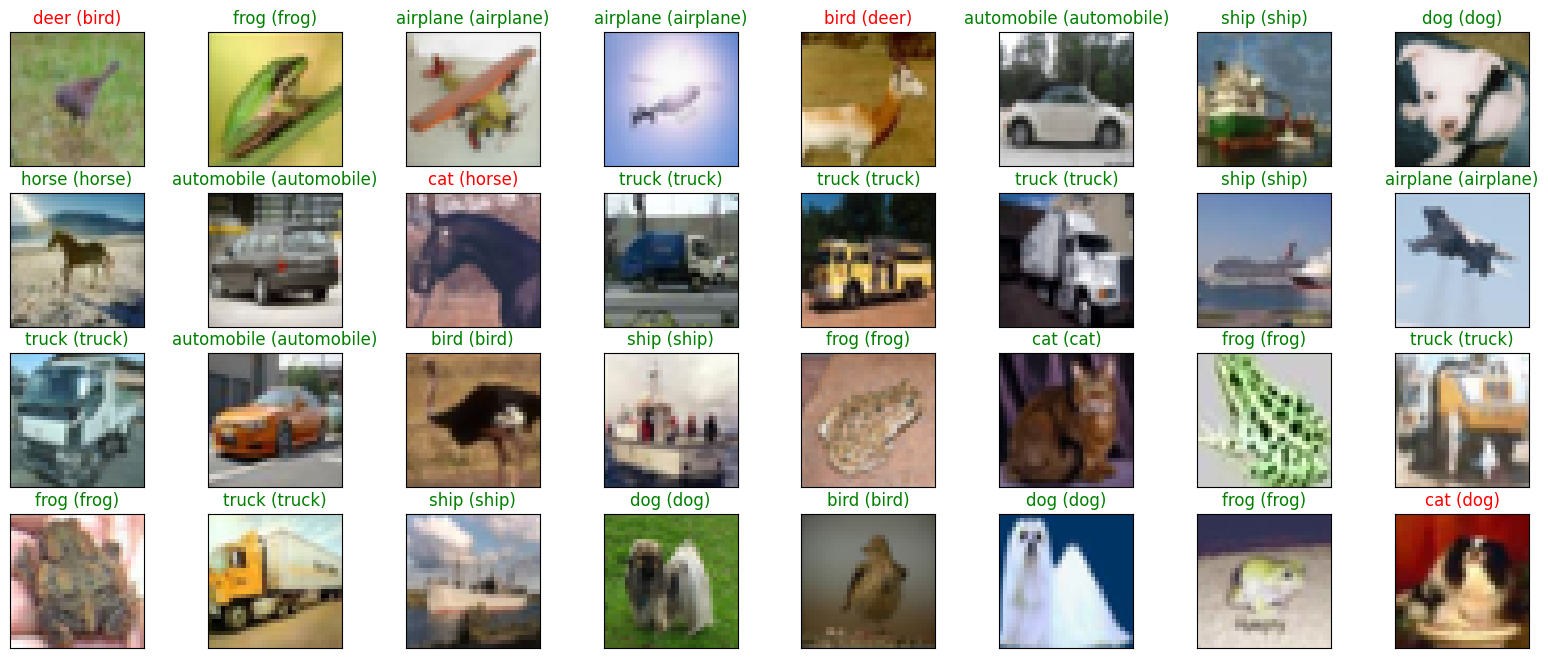

In [52]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))



> Confusion Matrix and Classification report



313/313 [==============================] - 2s 5ms/step


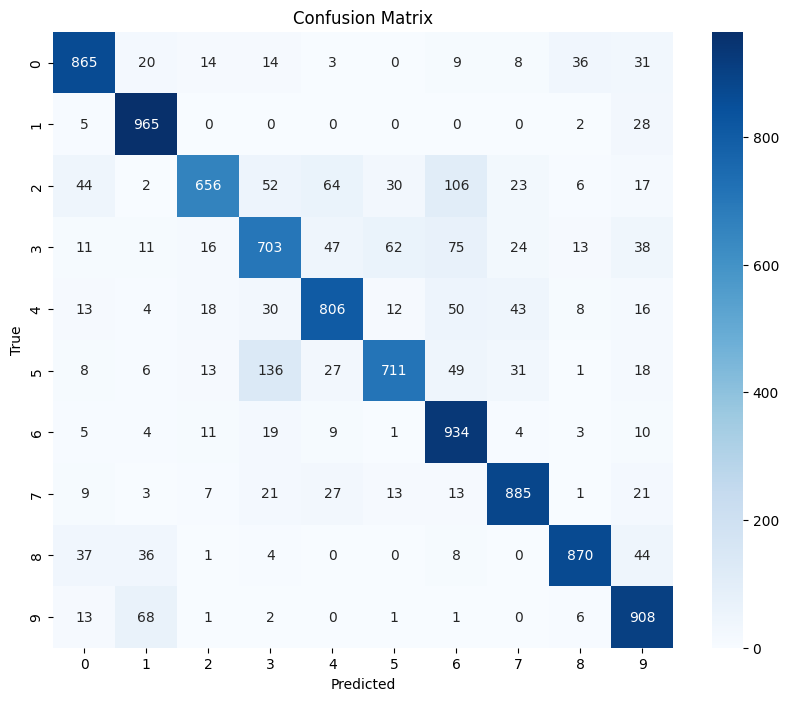


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1000
           1       0.86      0.96      0.91      1000
           2       0.89      0.66      0.76      1000
           3       0.72      0.70      0.71      1000
           4       0.82      0.81      0.81      1000
           5       0.86      0.71      0.78      1000
           6       0.75      0.93      0.83      1000
           7       0.87      0.89      0.88      1000
           8       0.92      0.87      0.89      1000
           9       0.80      0.91      0.85      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

# Make predictions
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
pyplot.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
pyplot.xlabel('Predicted')
pyplot.ylabel('True')
pyplot.title('Confusion Matrix')
pyplot.show()

# Print classification report
class_report = classification_report(true_labels, predicted_labels)
print("\nClassification Report:")
print(class_report)

Auto Hyperparameters optimization

In [56]:
!pip install optuna --q
import optuna

# Create an empty DataFrame to store the results
results_data = {'Base Hidden Units': [], 'Weight Decay': [], 'Learning Rate': [], 'Accuracy': []}

# Define the objective function
def objective(trial):
    # Number of hidden units
    base_hidden_units = trial.suggest_int('config.base_hidden_units', 16, 128, log=True)

    # L2 regularization hyperparameter (weight decay)
    weight_decay = trial.suggest_float('config.weight_decay', 1e-6, 1e-2, log=True)

    learning_rate = trial.suggest_float('config.learning_rate', 1e-5, 1e-1, log=True)

    # Evaluate the model on the validation set
    _, accuracy = model.evaluate(x_test, y_test)

    # Append the results to the DataFrame
    results_data['Base Hidden Units'].append(base_hidden_units)
    results_data['Weight Decay'].append(weight_decay)
    results_data['Learning Rate'].append(learning_rate)
    results_data['Accuracy'].append(accuracy)
    return accuracy

# Set up the study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2023-12-10 12:32:26,027] A new study created in memory with name: no-name-6a3a14d2-0dd5-462b-b5d1-2fac36a8df41


313/313 [==============================] - 2s 7ms/step - loss: 0.7692 - accuracy: 0.8303


[I 2023-12-10 12:32:28,913] Trial 0 finished with value: 0.830299973487854 and parameters: {'config.base_hidden_units': 24, 'config.weight_decay': 0.004001731576562608, 'config.learning_rate': 0.023567437422685567}. Best is trial 0 with value: 0.830299973487854.


313/313 [==============================] - 2s 6ms/step - loss: 0.7692 - accuracy: 0.8303


[I 2023-12-10 12:32:31,930] Trial 1 finished with value: 0.830299973487854 and parameters: {'config.base_hidden_units': 26, 'config.weight_decay': 0.009391122504068462, 'config.learning_rate': 0.005826474822560618}. Best is trial 0 with value: 0.830299973487854.


313/313 [==============================] - 2s 6ms/step - loss: 0.7692 - accuracy: 0.8303


[I 2023-12-10 12:32:34,810] Trial 2 finished with value: 0.830299973487854 and parameters: {'config.base_hidden_units': 75, 'config.weight_decay': 6.476771811722844e-05, 'config.learning_rate': 0.028579489579693355}. Best is trial 0 with value: 0.830299973487854.


313/313 [==============================] - 2s 6ms/step - loss: 0.7692 - accuracy: 0.8303


[I 2023-12-10 12:32:37,695] Trial 3 finished with value: 0.830299973487854 and parameters: {'config.base_hidden_units': 105, 'config.weight_decay': 0.0005442072120251394, 'config.learning_rate': 3.906455926301829e-05}. Best is trial 0 with value: 0.830299973487854.


313/313 [==============================] - 2s 6ms/step - loss: 0.7692 - accuracy: 0.8303


[I 2023-12-10 12:32:39,948] Trial 4 finished with value: 0.830299973487854 and parameters: {'config.base_hidden_units': 58, 'config.weight_decay': 2.6017984400822567e-06, 'config.learning_rate': 3.2402732936311766e-05}. Best is trial 0 with value: 0.830299973487854.


313/313 [==============================] - 2s 7ms/step - loss: 0.7692 - accuracy: 0.8303


[I 2023-12-10 12:32:42,884] Trial 5 finished with value: 0.830299973487854 and parameters: {'config.base_hidden_units': 46, 'config.weight_decay': 2.5830926074436507e-06, 'config.learning_rate': 0.010089376749111395}. Best is trial 0 with value: 0.830299973487854.


313/313 [==============================] - 2s 6ms/step - loss: 0.7692 - accuracy: 0.8303


[I 2023-12-10 12:32:45,215] Trial 6 finished with value: 0.830299973487854 and parameters: {'config.base_hidden_units': 18, 'config.weight_decay': 0.0006774183625178549, 'config.learning_rate': 0.004758921186042797}. Best is trial 0 with value: 0.830299973487854.


313/313 [==============================] - 2s 6ms/step - loss: 0.7692 - accuracy: 0.8303


[I 2023-12-10 12:32:48,099] Trial 7 finished with value: 0.830299973487854 and parameters: {'config.base_hidden_units': 29, 'config.weight_decay': 2.2181169129348608e-05, 'config.learning_rate': 0.029605724610445108}. Best is trial 0 with value: 0.830299973487854.


313/313 [==============================] - 2s 6ms/step - loss: 0.7692 - accuracy: 0.8303


[I 2023-12-10 12:32:50,975] Trial 8 finished with value: 0.830299973487854 and parameters: {'config.base_hidden_units': 111, 'config.weight_decay': 0.0016582969001518956, 'config.learning_rate': 3.326986702905028e-05}. Best is trial 0 with value: 0.830299973487854.


313/313 [==============================] - 2s 6ms/step - loss: 0.7692 - accuracy: 0.8303


[I 2023-12-10 12:32:53,225] Trial 9 finished with value: 0.830299973487854 and parameters: {'config.base_hidden_units': 72, 'config.weight_decay': 0.0002235479897013243, 'config.learning_rate': 0.017773475918304617}. Best is trial 0 with value: 0.830299973487854.


In [55]:
import pandas as pd

# Convert the results data to a DataFrame
results_df = pd.DataFrame(results_data)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Display the results DataFrame
print("\nResults Table:")
print(results_df)

Best Hyperparameters: {'config.base_hidden_units': 21, 'config.weight_decay': 0.002465187152688293, 'config.learning_rate': 0.005162505935493177}

Results Table:
   Base Hidden Units  Weight Decay  Learning Rate  Accuracy
0                 21      0.002465       0.005163    0.8303
1                 27      0.000200       0.002157    0.8303
2                127      0.008437       0.001297    0.8303
3                 22      0.000003       0.011092    0.8303
4                 48      0.000229       0.000063    0.8303
5                 55      0.000054       0.000583    0.8303
6                 34      0.001767       0.040526    0.8303
7                 57      0.005652       0.000060    0.8303
8                 18      0.000739       0.000017    0.8303
9                 20      0.000038       0.000059    0.8303
